#1. Import Libraries/Dataset

a. Import required libraries(Using keras library)

In [ ]:
import numpy as np
from numpy import mean,std,dstack,unique
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas.plotting import scatter_matrix
import seaborn as sns
import os
from sklearn import datasets
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from keras.utils import to_categorical
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv1D,MaxPooling1D,LSTM
from google.colab import drive
from keras.layers import TimeDistributed
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


b. Check the GPU available


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7979098103552022385
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15692777408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18350398827399939328
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# 2. Data Pre-processing

a. **Load file**
The load_file() function below loads a dataset given the fill path to the file and returns the loaded data as a NumPy array.

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

b.**Load Group**
The load_group() function below implements this behavior. The dstack() NumPy function allows us to stack each of the loaded 3D arrays into a single 3D array where the variables are separated on the third dimension (features)

In [ ]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

c. **Load dataset group**
The load_dataset_group() function below loads all input signal data and the output data for a single group using the consistent naming conventions between the directories.

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

d. **Load dataset**
The load_dataset() function below implements this behavior and returns the train and test X and y elements ready for fitting and evaluating the defined models.

In [ ]:

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix )
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix )
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print('Shapes',trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy


In [ ]:
# load data
drive.mount('/gdrive')
%cd /gdrive 
TRAIN = "train/"
TEST = "test/"
DATASET_PATH='/gdrive/My Drive/Colab Notebooks/Problem7/UCI HAR Dataset/'

trainX, trainy, testX, testy = load_dataset(DATASET_PATH)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Shapes (7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


# 3. Data Visualization


In [ ]:
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]

In [ ]:
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series

In [ ]:
def plot_subject(X, y):
	pyplot.figure()
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
	pyplot.show()

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 6)


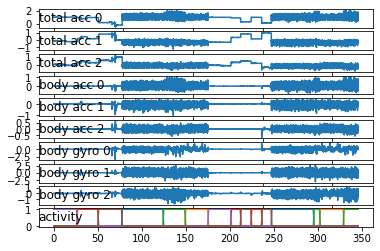

In [ ]:

sub_map = load_file('/gdrive/My Drive/Colab Notebooks/Problem7/UCI HAR Dataset/train/subject_train.txt')
train_subjects = unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(341, 128, 9) (341, 6)


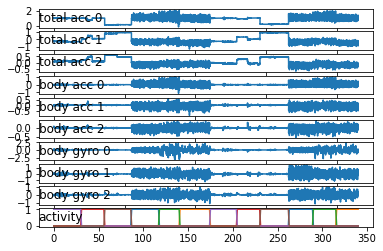

In [ ]:
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[1]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
# plot data for subject
plot_subject(subX, suby)

#Model 1: Develop an LSTM Network Model

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 32
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(LSTM(32, return_sequences=True,
               input_shape=(n_timesteps, n_features)))  # returns a sequence of vectors of dimension 32
  model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
  model.add(LSTM(32))  # return a single vector of dimension 32
  # model.add(LSTM(49))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  print('Summary-----',model.summary())
  # fit network
  history= model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(trainX, trainy))
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
  #                    validation_data=(trainX, trainy))

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  pyplot.plot(epochs, acc, 'r', label='Training accuracy')
  pyplot.plot(epochs, val_acc, 'b', label='Validation accuracy')
  pyplot.title('Training and validation accuracy')
  pyplot.legend(loc=0)
  pyplot.figure()

  pyplot.plot(epochs, loss, 'r', label='Training loss')
  pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
  pyplot.title('Training and validation loss')
  pyplot.legend(loc=0)

  pyplot.show()
  
  # evaluate model

  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy


The function summarize_results() below summarizes the results of a run.

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

We can bundle up the repeated evaluation, gathering of results, and summarization of results into a main function for the experiment, called run_experiment(), listed below.

By default, the model is evaluated 10 times before the performance of the model is reported.

In [ ]:

# run an experiment
def run_experiment(repeats=10):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
 


To execute the main method for running the LSTM to get 
the final test/validation loss and accuracy.

Running the example first prints the shape of the loaded dataset, then the shape of the train and test sets and the input and output elements. This confirms the number of samples, time steps, and variables, as well as the number of classes.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 32)           5376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               3300      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 25,922
Trainable params: 25,922
Non-trainable params: 0
____________________________________________________

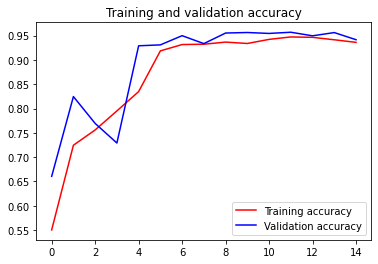

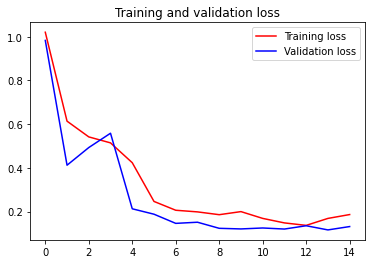

>#1: 89.311
[89.31116461753845]
Accuracy: 89.311% (+/-0.000)


In [ ]:
 # lstm model
run_experiment(repeats=1)

Confusion matrix cannot implemented as multiclass cannot create confusion matrix

#Model 2: Develop a CNN-LSTM Network Model 

The entire CNN model can be wrapped in a TimeDistributed layer to allow the same CNN model to read in each of the four subsequences in the window. The extracted features are then flattened and provided to the LSTM model to read, extracting its own features before a final mapping to an activity is made.

In [ ]:
def evaluate_cnn_lstm_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 0, 15, 256
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  model = Sequential()
  model.add(Conv1D(50, 3, input_shape=(128, 9), activation='tanh',kernel_initializer = 'he_normal'))
  model.add(MaxPooling1D(2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))


  model.add(Conv1D(100, 3, activation='tanh',kernel_initializer = 'he_normal'))
  model.add(MaxPooling1D(2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(LSTM(32, return_sequences=True,
               input_shape=(n_timesteps, n_features)))  # returns a sequence of vectors of dimension 32
  model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
  model.add(LSTM(32))  # return a single vector of dimension 32
  # model.add(LSTM(49))
  model.add(Dropout(0.5))
  model.add(Dense(100, activation='relu'))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  print('CNN LSTM Model Summary',model.summary())
  history= model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(trainX, trainy))
  #history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
  #                    validation_data=(trainX, trainy))

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  pyplot.plot(epochs, acc, 'r', label='Training accuracy')
  pyplot.plot(epochs, val_acc, 'b', label='Validation accuracy')
  pyplot.title('Training and validation accuracy')
  pyplot.legend(loc=0)
  pyplot.figure()

  pyplot.plot(epochs, loss, 'r', label='Training loss')
  pyplot.plot(epochs, val_loss, 'b', label='Validation loss')
  pyplot.title('Training and validation loss')
  pyplot.legend(loc=0)

  pyplot.show()
  
  # evaluate model

  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
  return accuracy

Adam--Computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters.We are using a modest learning rate of 0.001 which is good general starting points. The model will optimize the categorical cross entropy loss function required for multi-class classification and will monitor classification accuracy.

In [ ]:

# run an experiment
def run_cnn_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset(DATASET_PATH)
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_cnn_lstm_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Shapes (7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 50)           1400      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 63, 50)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 50)            200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 61, 100)           15100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 100)           0         
_____________

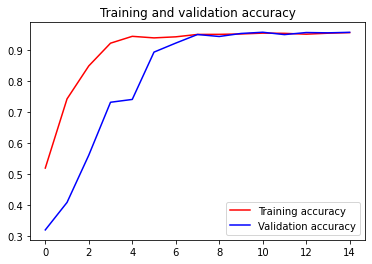

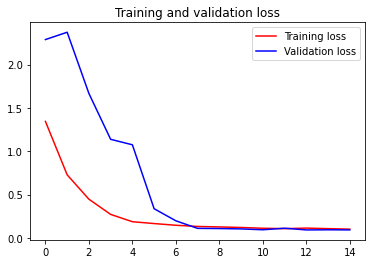

>#1: 91.517
[91.51679873466492]
Accuracy: 91.517% (+/-0.000)


In [ ]:
 # lstm model
run_cnn_experiment(repeats=1)

As with the prior experiments, running the model prints the performance of the model each time it is fit and evaluated. A summary of the final model performance is presented at the end of the run.

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

We can see that the model does consistently perform well on the problem achieving an accuracy of about 90%, perhaps with fewer resources than the larger CNN LSTM model.

**Data Preparation**. Consider exploring whether simple data scaling schemes can further lift model performance, such as normalization, standardization, and power transforms.

**LSTM Variations**. There are variations of the LSTM architecture that may achieve better performance on this problem, such as stacked LSTMs and Bidirectional LSTMs.

**Hyperparameter Tuning**. Consider exploring tuning of model hyperparameters such as the number of units, training epochs, batch size, and more.